# Imputation results of scPI-based methods (Cortex)

In [1]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import time
from scPI import scPI_FA
from scPI import scPI_ZIFA
from scPI import scPI_ZINB
from utils import *
from sklearn.decomposition import FactorAnalysis
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score as NMI
from sklearn.metrics import adjusted_rand_score as ARI
def cluster_scores(latent_space, K, labels_true):
    labels_pred = KMeans(K, n_jobs=8, n_init=20).fit_predict(latent_space)
    return [silhouette_score(latent_space, labels_true), NMI(labels_true, labels_pred), ARI(labels_true, labels_pred)]
n_celltype = 7
n_repeat = 10

In [2]:
def imputation_error(X_mean, X, X_zero, i, j, ix):
    """
    X_mean: imputed dataset
    X: original dataset
    X_zero: zeros dataset
    i, j, ix: indices of where dropout was applied
    ========
    returns:
    median L1 distance between datasets at indices given
    """
    all_index = i[ix], j[ix]
    x, y = X_mean[all_index], X[all_index]
    return np.median(np.abs(x - y))

X = np.loadtxt("/Users/jiazhao/Downloads/Results/Cortex/data_train", dtype='float32')
X_zero = np.loadtxt("/Users/jiazhao/Downloads/Results/Cortex/imputation/X_zero.txt", dtype='float32')
data_path = "/Users/jiazhao/Downloads/Results/Cortex/imputation/"
i = np.load(data_path + "i.npy")
j = np.load(data_path + "j.npy")
ix = np.load(data_path + "ix.npy")
n_repeat = 10

### example of performing scPI-FA, scPI-ZIFA, scPI-ZINB (vary n_epoch and linearity)

When evaluating the impact of the number of epochs, we vary n_epoch to be $\{250,500,10000\}$. When evaluating the impact of the linearity and non-linearity, we vary non_linear to be False or True. We repeat the experiments ten times to draw boxplots. Note: we use learning rate 1e-3 for scPI-ZIFA-linear, and learning rate 5e-4 for all the other methods.

In [ ]:
X_zero = np.log(np.loadtxt(data_path + "X_zero.txt", dtype='float32') + 1)
n_repeat = 10
file_name = "scPI_FA"
for k in range(n_repeat):
    result, result_test = scPI_FA.fitModel(Y=X_zero, K=10, batch_size=128, n_epoch=500, lr=5e-4, non_linear=True, Y_test=None)
    A = result["A"]
    Z = result["latent"]
    mu = result["mu"]
    X_impu = np.exp(Z @ A.T + mu.reshape([1, D])) - 1
    impu_err = imputation_error(X_impu, X_true, np.exp(X_zero)-1, i, j, ix)
    np.savetxt(str(k) + file_name + '_imperr.txt', np.array(impu_err).reshape([-1]))

In [ ]:
n_repeat = 10
file_name = "scPI_ZIFA"
for k in range(n_repeat):
    result, result_test = scPI_ZIFA.fitModel(Y=expression_train, K=10, batch_size=128, n_epoch=500, lr=5e-4, act_nng_exp=True, non_linear=True, Y_test=None)
    # save training results
    A = result["A"]
    Z = result["latent"]
    mu = result["mu"]
    X_impu = np.exp(Z @ A.T + mu.reshape([1, D])) - 1
    impu_err = imputation_error(X_impu, X_true, np.exp(expression_train)-1, i, j, ix)
    np.savetxt(str(k) + file_name + '_imperr.txt', np.array(impu_err).reshape([-1]))

In [ ]:
n_repeat = 10
file_name = "scPI_ZINB"
for k in range(n_repeat):
    result, result_test = scPI_ZINB.fitModel(Y=expression_train, K=10, batch_size=128, n_epoch=500, lr=5e-4, non_linear=True, act_nn_exp=True, Y_test=None)
    # save training results
    X_impu = result["rho"]
    impu_err = imputation_error(X_impu, X_true, expression_train, i, j, ix)
    np.savetxt(str(k) + file_name + '_imperr.txt', np.array(impu_err).reshape([-1]))

### Impact of the number of epochs on imputation error

In [5]:
# ZIFA 
n_repeat = 10
zifa = np.zeros([n_repeat,])
N, D = X_zero.shape
data_path = "/Users/jiazhao/Downloads/Results/Cortex/ZIFA/"
A  = np.loadtxt(data_path + "0impu_CORTEX_ZIFA_A.txt")
mu = np.loadtxt(data_path + "0impu_CORTEX_ZIFA_mus.txt")
Z  = np.loadtxt(data_path + "0impu_CORTEX_ZIFA_Z.txt")
Xtilde = Z @ A.T + mu.reshape([1, D])
imp_err = imputation_error(np.exp(Xtilde)-1, X, X_zero, i, j, ix)
for t in range(n_repeat):
    zifa[t] = imp_err

# ZINB
zinb = np.zeros([n_repeat,])
data_path = "/Users/jiazhao/Downloads/Results/Cortex/ZINB/"
for t in range(n_repeat):
    Xtilde  = np.loadtxt(data_path + str(t) + "impu_CORTEX_ZINB_Xtilde.txt")
    imp_err = imputation_error(Xtilde, X, X_zero, i, j, ix)
    zinb[t] = imp_err

# FA
fa = np.zeros([n_repeat,])
data_path = "/Users/jiazhao/Downloads/Results/Cortex/FA/imputation/"
for t in range(n_repeat):
    fa[t]  = np.loadtxt(data_path + str(t) + "impu_CORTEX_FA_imperr.txt")

# zifa-nln
zifa_nln = np.zeros([n_repeat,])
data_path = "/Users/jiazhao/Downloads/Results/Cortex/scPI_ZIFA/500-impu/"
for t in range(n_repeat):
    zifa_nln[t]  = np.loadtxt(data_path + str(t) + "impu_CORTEX_ZIFAVAE_nonlinear_imperr.txt")

# zifa-nln
zifa_nln_1w = np.zeros([n_repeat,])
data_path = "/Users/jiazhao/Downloads/Results/Cortex/scPI_ZIFA/10K-impu/"
for t in range(n_repeat):
    zifa_nln_1w[t]  = np.loadtxt(data_path + str(t) + "impu_CORTEX_ZIFAVAE_nonlinear_imperr.txt")

# zifa-nln
zifa_nln_250 = np.zeros([n_repeat,])
data_path = "/Users/jiazhao/Downloads/Results/Cortex/scPI_ZIFA/250-impu/"
for t in range(n_repeat):
    zifa_nln_250[t]  = np.loadtxt(data_path + str(t) + "impu_CORTEX_ZIFAVAE_nonlinear_imperr.txt")

# zinb-nln
zinb_nln = np.zeros([n_repeat,])
data_path = "/Users/jiazhao/Downloads/Results/Cortex/scPI_ZINB/500-impu/"
for t in range(n_repeat):
    zinb_nln[t]  = np.loadtxt(data_path + str(t) + "impu_CORTEX_ZINBVAE_nonlinear_imperr.txt")

# zinb-nln
zinb_nln_1w = np.zeros([n_repeat,])
data_path = "/Users/jiazhao/Downloads/Results/Cortex/scPI_ZINB/10K-impu/"
for t in range(n_repeat):
    zinb_nln_1w[t]  = np.loadtxt(data_path + str(t) + "impu_CORTEX_ZINBVAE_nonlinear_imperr.txt")

# zinb-nln
zinb_nln_250 = np.zeros([n_repeat,])
data_path = "/Users/jiazhao/Downloads/Results/Cortex/scPI_ZINB/250-impu/"
for t in range(n_repeat):
    zinb_nln_250[t]  = np.loadtxt(data_path + str(t) + "impu_CORTEX_ZINBVAE_nonlinear_imperr.txt")

# fa-nln
fa_nln = np.zeros([n_repeat,])
data_path = "/Users/jiazhao/Downloads/Results/Cortex/scPI_FA/500-impu/"
for t in range(n_repeat):
    fa_nln[t]  = np.loadtxt(data_path + str(t) + "impu_CORTEX_FAVAE_nonlinear_imperr.txt")

# fa-nln
fa_nln_1w = np.zeros([n_repeat,])
data_path = "/Users/jiazhao/Downloads/Results/Cortex/scPI_FA/10K-impu/"
for t in range(n_repeat):
    fa_nln_1w[t]  = np.loadtxt(data_path + str(t) + "impu_CORTEX_FAVAE_nonlinear_imperr.txt")

# fa-nln
fa_nln_250 = np.zeros([n_repeat,])
data_path = "/Users/jiazhao/Downloads/Results/Cortex/scPI_FA/250-impu/"
for t in range(n_repeat):
    fa_nln_250[t]  = np.loadtxt(data_path + str(t) + "impu_CORTEX_FAVAE_nonlinear_imperr.txt")


In [6]:
n_repeat = 10
model = list("FA" for _ in range(n_repeat)) + \
        list("scPI-FA-10K" for _ in range(n_repeat)) + \
        list("scPI-FA-500" for _ in range(n_repeat)) + \
        list("scPI-FA-250" for _ in range(n_repeat)) + \
        list("ZIFA" for _ in range(n_repeat)) + \
        list("scPI-ZIFA-10K" for _ in range(n_repeat)) + \
        list("scPI-ZIFA-500" for _ in range(n_repeat)) + \
        list("scPI-ZIFA-250" for _ in range(n_repeat)) + \
        list("ZINB" for _ in range(n_repeat)) + \
        list("scPI-ZINB-10K" for _ in range(n_repeat)) + \
        list("scPI-ZINB-500" for _ in range(n_repeat)) + \
        list("scPI-ZINB-250" for _ in range(n_repeat))
error = list(fa) + list(fa_nln_1w) + list(fa_nln) + list(fa_nln_250) + \
        list(zifa) + list(zifa_nln_1w) + list(zifa_nln) + list(zifa_nln_250) + \
        list(zinb) + list(zinb_nln_1w) + list(zinb_nln) + list(zinb_nln_250)

Text(0.5,1,'Cortex')

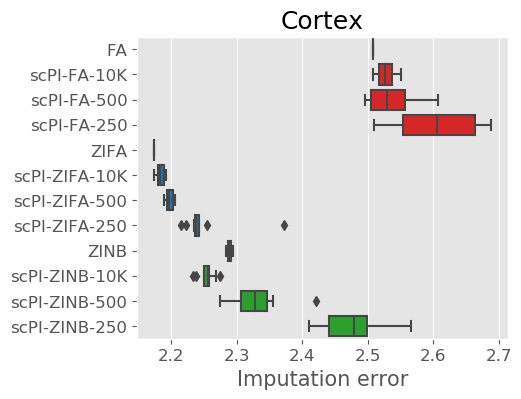

In [7]:
d = {'model': model, 'error': error}
df = pd.DataFrame(data=d)
fig = plt.figure(dpi=100)
grid = plt.GridSpec(1, 10, wspace=0.2, hspace=0.2)
ax = plt.subplot(grid[:, 2:10])
sns.boxplot(y="model", x="error", data=df)
ax.artists[0].set_facecolor('tab:red')
ax.artists[1].set_facecolor('tab:red')
ax.artists[2].set_facecolor('tab:red')
ax.artists[3].set_facecolor('tab:red')
ax.artists[4].set_facecolor('tab:blue')
ax.artists[5].set_facecolor('tab:blue')
ax.artists[6].set_facecolor('tab:blue')
ax.artists[7].set_facecolor('tab:blue')
ax.artists[8].set_facecolor('tab:green')
ax.artists[9].set_facecolor('tab:green')
ax.artists[10].set_facecolor('tab:green')
ax.artists[11].set_facecolor('tab:green')
plt.xlabel('Imputation error', fontsize=15)
plt.ylabel('', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Cortex", fontsize=18)

### Impact of the linearity on imputation error

In [11]:
# zifa-ln
zifa_ln = np.zeros([n_repeat,])
data_path = "/Users/jiazhao/Downloads/Results/Cortex/scPI_ZIFA_linear/500-impu/"
for t in range(n_repeat):
    zifa_ln[t]  = np.loadtxt(data_path + str(t) + "impu_CORTEX_ZIFAVAE_linear_imperr.txt")

# zinb-ln
zinb_ln = np.zeros([n_repeat,])
data_path = "/Users/jiazhao/Downloads/Results/Cortex/scPI_ZINB_linear/500-impu/"
for t in range(n_repeat):
    zinb_ln[t]  = np.loadtxt(data_path + str(t) + "impu_CORTEX_ZINBVAE_linear_imperr.txt")

# fa-ln
fa_ln = np.zeros([n_repeat,])
data_path = "/Users/jiazhao/Downloads/Results/Cortex/scPI_FA_linear/500-impu/"
for t in range(n_repeat):
    fa_ln[t]  = np.loadtxt(data_path + str(t) + "impu_CORTEX_FAVAE_linear_imperr.txt")
    
# scvi
scvi = np.zeros([n_repeat,])
data_path = "/Users/jiazhao/Downloads/Results/Cortex/scVI/imputation/"
for t in range(n_repeat):
    scvi[t]  = np.loadtxt(data_path + str(t) + "impu_CORTEX_scVI_imperr.txt")

Text(0.5,1,'Cortex')

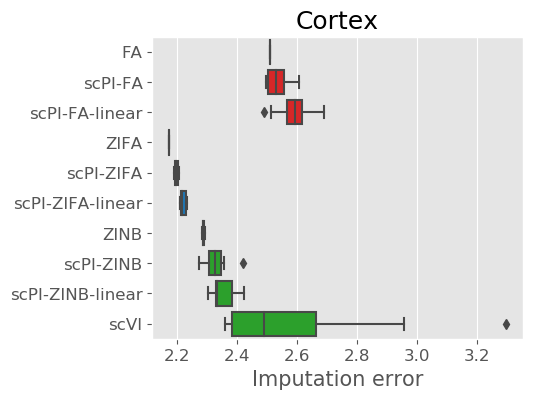

In [12]:
n_repeat = 10
model = list("FA" for _ in range(n_repeat)) + \
        list("scPI-FA" for _ in range(n_repeat)) + \
        list("scPI-FA-linear" for _ in range(n_repeat)) + \
        list("ZIFA" for _ in range(n_repeat)) + \
        list("scPI-ZIFA" for _ in range(n_repeat)) + \
        list("scPI-ZIFA-linear" for _ in range(n_repeat)) + \
        list("ZINB" for _ in range(n_repeat)) + \
        list("scPI-ZINB" for _ in range(n_repeat)) + \
        list("scPI-ZINB-linear" for _ in range(n_repeat)) + \
        list("scVI" for _ in range(n_repeat)) 
error = list(fa) + list(fa_nln) + list(fa_ln) + \
        list(zifa) + list(zifa_nln) + list(zifa_ln) + \
        list(zinb) + list(zinb_nln) + list(zinb_ln) + list(scvi)

d = {'model': model, 'error': error}
df = pd.DataFrame(data=d)
fig = plt.figure(dpi=100)
grid = plt.GridSpec(1, 10, wspace=0.2, hspace=0.2)
ax = plt.subplot(grid[:, 2:10])
sns.boxplot(y="model", x="error", data=df)
ax.artists[0].set_facecolor('tab:red')
ax.artists[1].set_facecolor('tab:red')
ax.artists[2].set_facecolor('tab:red')
ax.artists[3].set_facecolor('tab:blue')
ax.artists[4].set_facecolor('tab:blue')
ax.artists[5].set_facecolor('tab:blue')
ax.artists[6].set_facecolor('tab:green')
ax.artists[7].set_facecolor('tab:green')
ax.artists[8].set_facecolor('tab:green')
ax.artists[9].set_facecolor('tab:green')
plt.xlabel('Imputation error', fontsize=15)
plt.ylabel('', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Cortex", fontsize=18)